In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
os.chdir("../")

In [3]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from utils import augmentations as aug
import configs.full_cv_config as tr_test_config
from utils.data_loader import CDNet2014Loader
from utils.visualize import visualize

## DataLoader

In [4]:
# Variables
cuda = 0
set_number = 5
inp_size = (224, 224)
inp_scale = 1
empty_bg = 'manual'
recent_bg = 1
seg_ch = 1

In [5]:
# Spatio-Temporal Data Augmentations. Change these values for trying different variations
aug_noise = 1
aug_rsc = 1
aug_ptz = 1
aug_id = 1
aug_ioa = 0.1
debug = True

dataset = tr_test_config.datasets_tr[set_number]

# Augmentations
crop_and_aug = [aug.RandomCrop(inp_size)]

if aug_rsc:
    crop_and_aug.append(aug.RandomJitteredCrop(inp_size, debug=debug))
    
if aug_ptz:
    crop_and_aug.append(
            [
                aug.RandomZoomCrop(
                    inp_size,
                    debug=debug,
                    ),
                aug.RandomPanCrop(
                    inp_size,
                    debug=debug,
                ),
            ]
        )

additional_augs = []

if aug_id:
    ill_global, std_ill_diff = (0.1, 0.04), (0.1, 0.04)
    additional_augs.append([aug.AdditiveRandomIllumation(ill_global, std_ill_diff, debug=debug)])

if aug_ioa > 0:
    additional_augs_iom = []
    if aug_id:
        ill_global, std_ill_diff = (0.1, 0.04), (0.1, 0.04)
        additional_augs_iom.append([aug.AdditiveRandomIllumation(ill_global, std_ill_diff)])

    if aug_noise:
        noise = 0.01
        additional_augs_iom.append([aug.AdditiveNoise(noise)])

    iom_dataset = {
        'intermittentObjectMotion':dataset['intermittentObjectMotion']
    }
    mask_transforms = [
        [aug.RandomCrop(inp_size)],
        *additional_augs_iom,
    ]

    dataloader_mask = CDNet2014Loader(
        iom_dataset, 
        empty_bg=empty_bg, 
        recent_bg=recent_bg,
        segmentation_ch=seg_ch,
        transforms=mask_transforms,
        multiplier=0,
        shuffle=True
        )

    additional_augs.append([aug.RandomMask(inp_size, dataloader_mask, mask_prob=aug_ioa, debug=debug)])

if aug_noise:
    noise = 0.01
    additional_augs.append([aug.AdditiveNoise(noise, debug = debug)])

mean_rgb = [x for x in [0.485, 0.456, 0.406]]
std_rgb = [x for x in [0.229, 0.224, 0.225]]
mean_seg = [x for x in [0.5]]
std_seg = [x for x in [0.5]]

transforms = [
    crop_and_aug,
    *additional_augs,
    [aug.ToTensor()],
    [aug.NormalizeTensor(mean_rgb=mean_rgb, std_rgb=std_rgb,
                        mean_seg=mean_seg, std_seg=std_seg, segmentation_ch=seg_ch)]
]

In [6]:
# Dataloader
dataloader = CDNet2014Loader(
                    dataset, empty_bg=empty_bg, recent_bg=recent_bg,
                    segmentation_ch=seg_ch, transforms=transforms,
                    shuffle=True
)

#Tensorloader
tensorloader = torch.utils.data.DataLoader(
                    dataset=dataloader, batch_size=1, shuffle=True, num_workers=1)

## Visualize from dataloader

In [7]:
dataiter = iter(dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Applying Random Pan
Right Pan
Applying random illumination difference
Applying random noise


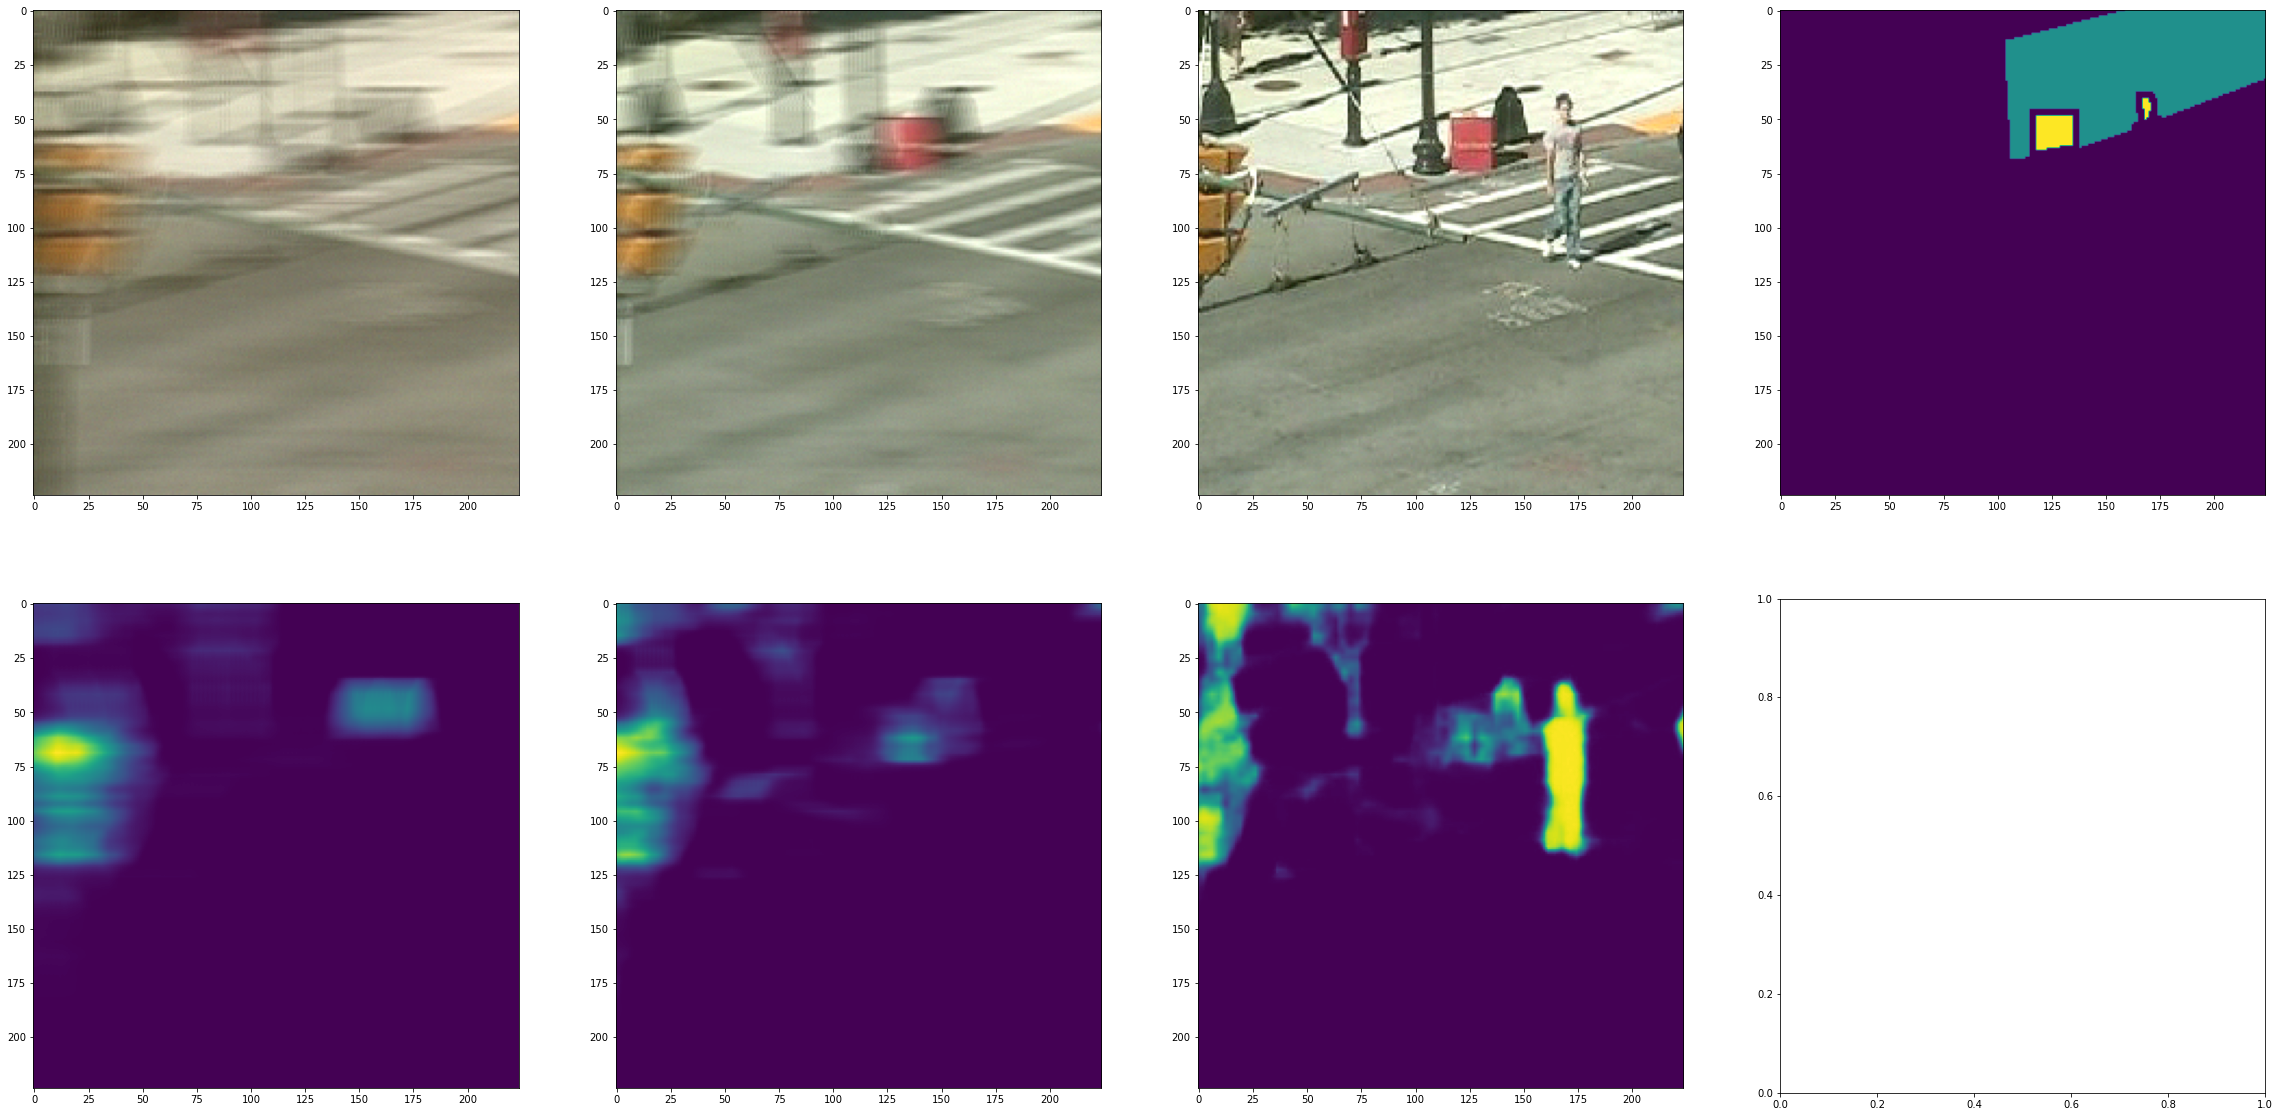

In [8]:
# Every run of this cell will produce a new input

import cv2

for k in range(1):
    data = next(dataiter)
inputs, labels = data[0].float().unsqueeze(0) * inp_scale, data[1].float().unsqueeze(0)

if cuda:
    inputs, labels = inputs.cuda(), labels.cuda()
im_arr = visualize(inputs, labels, segmentation_ch=seg_ch)
